In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
train_path = "../raw_data/UNSW_NB15_training-set.csv"
test_path  = "../raw_data/UNSW_NB15_testing-set.csv"

assert os.path.exists(train_path), "Arquivo de treino não encontrado"
assert os.path.exists(test_path), "Arquivo de teste não encontrado"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [5]:
# Identificar colunas categóricas
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Colunas categóricas removidas:", cat_cols)

# Remover categóricas
X_train = X_train.drop(columns=cat_cols)
X_test  = X_test.drop(columns=cat_cols)

X_train.shape, X_test.shape

Colunas categóricas removidas: ['proto', 'service', 'state']


((175341, 40), (82332, 40))

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [7]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32)

X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32)

In [8]:
train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test_t, y_test_t),
    batch_size=64,
    shuffle=False
)

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


model = MLP(X_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model

MLP(
  (net): Sequential(
    (0): Linear(in_features=40, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [10]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb).squeeze()
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

Epoch 1/10 - Loss: 0.1180
Epoch 2/10 - Loss: 0.0804
Epoch 3/10 - Loss: 0.0674
Epoch 4/10 - Loss: 0.0611
Epoch 5/10 - Loss: 0.0575
Epoch 6/10 - Loss: 0.0551
Epoch 7/10 - Loss: 0.0525
Epoch 8/10 - Loss: 0.0508
Epoch 9/10 - Loss: 0.0498
Epoch 10/10 - Loss: 0.0475


In [18]:
model.eval()

y_true = []
y_scores = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb).squeeze()
        probs = torch.sigmoid(logits)

        y_scores.extend(probs.cpu().numpy().ravel())
        y_true.extend(yb.numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)
y_pred = (y_scores >= 0.5).astype(int)

print(f"Accuracy : {accuracy_score(y_true, y_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_true, y_pred) * 100:.2f}%")
print(f"Recall   : {recall_score(y_true, y_pred) * 100:.2f}%")
print(f"ROC AUC  : {roc_auc_score(y_true, y_scores) * 100:.2f}%")

Accuracy : 55.78%
Precision: 64.53%
Recall   : 43.71%
ROC AUC  : 61.76%


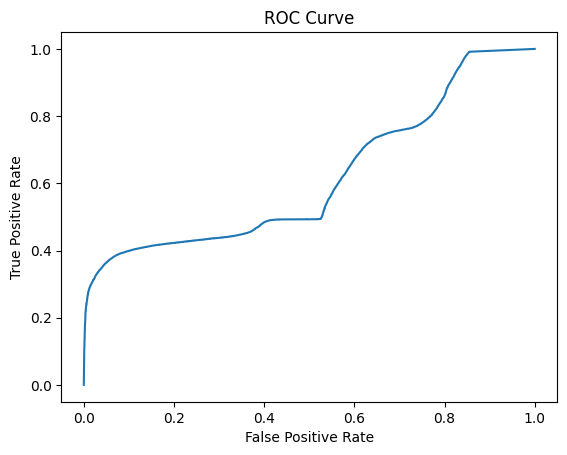

In [12]:
fpr, tpr, _ = roc_curve(y_true, y_scores)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()